<a href="https://www.kaggle.com/code/sharanharsoor/approach-using-lstm-time-series?scriptVersionId=126971201" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Idea
The objective of this competition is to track the progression of Parkinson's disease over time using historical data. To achieve this, transformed the problem into a time series analysis and employed the following strategies:

1. Initially, I attempted to utilize all available features. However, we had to remove 'Peptide' or 'PeptideAbundance' features from train_peptides due to submission failure.
2. To capture time series data, we created a sequence with a length of 50.
3. Finally, we used an LSTM network for making predictions.

Although our model fell short of expectations, there is considerable room for improvement in this notebook for achieving better results.

In [1]:
import pandas as pd
import amp_pd_peptide
import numpy as np
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
import copy
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
from tensorflow import keras
import time


In [2]:
clinical = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
print(clinical.shape)
clinical.head(2)

(2615, 8)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN


In [3]:
clinical.isnull().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64

In [4]:
clinical['updrs_1'].fillna((clinical['updrs_1'].mean()), inplace=True)
clinical['updrs_2'].fillna((clinical['updrs_2'].mean()), inplace=True)
clinical['updrs_3'].fillna((clinical['updrs_3'].mean()), inplace=True)
clinical.drop(['upd23b_clinical_state_on_medication'],axis = 1, inplace = True)
clinical['updrs_4'].fillna(0, inplace=True)
clinical.isnull().sum()

visit_id       0
patient_id     0
visit_month    0
updrs_1        0
updrs_2        0
updrs_3        0
updrs_4        0
dtype: int64

In [5]:
proteins = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
print(proteins.shape)
print(proteins.isnull().sum().sum())
proteins.head(2)

(232741, 5)
0


,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0


In [6]:
peptides = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
print(peptides.shape)
print(peptides.isnull().sum().sum())
peptides.head(2)

(981834, 6)
0


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0


In [7]:
def cycle_cehck(all_merge):
    temp_cycle = []
    same_cycle = 1
    for i, j in all_merge.iterrows():
        if i == 0:
            prev_visit_id = j.visit_id
            prev_patient_id = j.patient_id
            prev_visit_month = j.visit_month
            same_cycle = 1
            temp_cycle.append(same_cycle)
            continue 
    
    
        if((prev_patient_id == j.patient_id) and (prev_visit_month == j.visit_month)):
            temp_cycle.append(same_cycle)
        elif((prev_patient_id == j.patient_id) and (prev_visit_month != j.visit_month)):
            prev_visit_id = j.visit_id
            prev_patient_id = j.patient_id
            prev_visit_month = j.visit_month
            same_cycle += 1
            temp_cycle.append(same_cycle)
        else:
            prev_visit_id = j.visit_id
            prev_patient_id = j.patient_id
            prev_visit_month = j.visit_month
            same_cycle = 1
            temp_cycle.append(same_cycle)
    return temp_cycle

In [8]:
# write a function for all above, use same for test and see the test data as train.
# start LSTM 

In [9]:
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=999)
min_max_scaler = preprocessing.MinMaxScaler()

In [10]:
def data_prep(clinical, peptides, proteins, train=1):
    
    #proteins_peptides = proteins.merge(peptides, how='inner', on=['visit_id','visit_month','patient_id','UniProt'])
    #all_merge = clinical.merge(proteins_peptides, how='left', on=['visit_id', 'visit_month', 'patient_id'])
    
    all_merge = clinical.merge(proteins, how='left', on=['visit_id', 'visit_month', 'patient_id'])

    all_merge['UniProt'].fillna("other", inplace=True)
    all_merge['NPX'].fillna((all_merge['NPX'].mean()), inplace=True)
    #all_merge['Peptide'].fillna("other", inplace=True)
    #all_merge['PeptideAbundance'].fillna((all_merge['PeptideAbundance'].mean()), inplace=True)
    '''
    if(train):
        all_merge[["UniProt","Peptide"]] =\
        enc.fit_transform(all_merge[["UniProt","Peptide"]])
    else :
        all_merge[["UniProt","Peptide"]] =\
        enc.transform(all_merge[["UniProt","Peptide"]])
    '''
    if(train):
        all_merge[["UniProt"]] =\
        enc.fit_transform(all_merge[["UniProt"]])
    else :
        all_merge[["UniProt"]] =\
        enc.transform(all_merge[["UniProt"]])

        
    temp_cycle = cycle_cehck(all_merge)
    all_merge['cycle'] = temp_cycle
    
    if(train):
        #all_merge.drop(['visit_id', 'patient_id'],axis = 1, inplace = True)
        cols_normalize = all_merge.columns.difference(['updrs_1','updrs_2','updrs_3','updrs_4','visit_id','patient_id'])
        norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(all_merge[cols_normalize]), 
                             columns=cols_normalize, 
                             index=all_merge.index)
        join_df = all_merge[['updrs_1','updrs_2','updrs_3','updrs_4','visit_id','patient_id']].join(norm_train_df)
        all_merge = join_df.reindex(columns = all_merge.columns)
    else :
        all_merge['month_raw'] =  copy.deepcopy(all_merge.loc[:, 'visit_month'])
        cols_normalize = all_merge.columns.difference(['visit_id','patient_id','updrs_test','row_id','month_raw'])
        norm_train_df = pd.DataFrame(min_max_scaler.transform(all_merge[cols_normalize]), 
                             columns=cols_normalize, 
                             index=all_merge.index)
        join_df = all_merge[['visit_id','patient_id','updrs_test','row_id','month_raw']].join(norm_train_df)
        all_merge = join_df.reindex(columns = all_merge.columns)
    
    return all_merge

In [11]:
data_prep_train = data_prep(clinical, peptides, proteins, train=1)
data_prep_train.head(5)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,UniProt,NPX,cycle
0,55_0,55,0.0,10.0,6.0,15.0,0.0,0.000000,0.000018,0.0
1,55_0,55,0.0,10.0,6.0,15.0,0.0,0.004405,0.001193,0.0
2,55_0,55,0.0,10.0,6.0,15.0,0.0,0.008811,0.000064,0.0
3,55_0,55,0.0,10.0,6.0,15.0,0.0,0.013216,0.000068,0.0
4,55_0,55,0.0,10.0,6.0,15.0,0.0,0.017621,0.000051,0.0


In [12]:
# test and submission.

submission = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv")

test_proteins = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv")
test_proteins.drop(['group_key'],axis = 1, inplace = True)

test_peptides = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv")
test_peptides.drop(['group_key'],axis = 1, inplace = True)

test_clinical = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test.csv")
test_clinical.drop(['group_key'],axis = 1, inplace = True)

data_prep_test = data_prep(test_clinical, test_peptides, test_proteins, train=0)
print(data_prep_test.shape)
data_prep_test.head(5)

(1820, 9)


,visit_id,visit_month,patient_id,updrs_test,row_id,UniProt,NPX,cycle,month_raw
0,3342_0,0.0,3342,updrs_1,3342_0_updrs_1,1.0,0.004827,0.0,0
1,3342_0,0.0,3342,updrs_2,3342_0_updrs_2,1.0,0.004827,0.0,0
2,3342_0,0.0,3342,updrs_3,3342_0_updrs_3,1.0,0.004827,0.0,0
3,3342_0,0.0,3342,updrs_4,3342_0_updrs_4,1.0,0.004827,0.0,0
4,50423_0,0.0,50423,updrs_1,50423_0_updrs_1,0.0,0.000054,0.0,0


In [13]:
test_clinical.head(2)

,visit_id,visit_month,patient_id,updrs_test,row_id
0,3342_0,0,3342,updrs_1,3342_0_updrs_1
1,3342_0,0,3342,updrs_2,3342_0_updrs_2


In [14]:
sequence_length = 50
def sequence_generator(feature_df, seq_length, seq_cols):
    if(feature_df.shape[0] < sequence_length):
        feature_df = pd.concat([feature_df, pd.concat([feature_df[-1:]]*(sequence_length+1 - feature_df.shape[0]))])
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [15]:
def label_generator(label_df, seq_length, label):
    if(label_df.shape[0] < sequence_length):
        label_df = pd.concat([label_df, pd.concat([label_df[-1:]]*(sequence_length+1 - label_df.shape[0]))])
    label_array = label_df[label].values
    num_elements = label_array.shape[0]    
    return label_array[seq_length:num_elements, :]

In [16]:
#seq_cols = ['visit_month','UniProt','NPX','Peptide','PeptideAbundance','cycle']
seq_cols = ['visit_month','UniProt','NPX','cycle']

In [17]:
def train_sed_gen(data_prep_train):
    seq_gen_train = (list(sequence_generator(data_prep_train[data_prep_train['patient_id'] == patient_id], sequence_length, seq_cols))
           for patient_id in data_prep_train['patient_id'].unique())

    #print(list(seq_gen))
    seq_gen_train = [ele for ele in seq_gen_train if ele != []]

    seq_gen_train_f = np.concatenate(list(seq_gen_train)).astype(np.float32)
    return seq_gen_train_f

In [18]:
seq_gen_train_f = train_sed_gen(data_prep_train)
seq_gen_train_f.shape

(212415, 50, 4)

In [19]:
def train_label_gen(data_prep_train, target):
    label_gen = [label_generator(data_prep_train[data_prep_train['patient_id'] == patient_id], sequence_length, [target]) 
             for patient_id in data_prep_train['patient_id'].unique()]
    label_set = np.concatenate(label_gen).astype(np.float32)
    return label_set

In [20]:
target_updrs_1 = train_label_gen(data_prep_train, 'updrs_1')
print(target_updrs_1.shape)
target_updrs_2 = train_label_gen(data_prep_train, 'updrs_2')
print(target_updrs_2.shape)
target_updrs_3 = train_label_gen(data_prep_train, 'updrs_3')
print(target_updrs_3.shape)
target_updrs_4 = train_label_gen(data_prep_train, 'updrs_4')
print(target_updrs_4.shape)

(212415, 1)
(212415, 1)
(212415, 1)
(212415, 1)


In [21]:
data_prep_test['row_id'].unique()

array(['3342_0_updrs_1', '3342_0_updrs_2', '3342_0_updrs_3',
       '3342_0_updrs_4', '50423_0_updrs_1', '50423_0_updrs_2',
       '50423_0_updrs_3', '50423_0_updrs_4', '3342_6_updrs_1',
       '3342_6_updrs_2', '3342_6_updrs_3', '3342_6_updrs_4',
       '50423_6_updrs_1', '50423_6_updrs_2', '50423_6_updrs_3',
       '50423_6_updrs_4'], dtype=object)

In [22]:
# test seq
def test_seq_gen(data_prep_test):
    seq_gen_test = (list(sequence_generator(data_prep_test[data_prep_test['row_id'] == row_id], sequence_length, seq_cols))
           for row_id in data_prep_test['row_id'].unique())

    #print(list(seq_gen))
    seq_gen_test = [ele for ele in seq_gen_test if ele != []]

    seq_gen_test_f = np.concatenate(list(seq_gen_test)).astype(np.float32)
    return seq_gen_test_f

In [23]:
seq_gen_test_f = test_seq_gen(data_prep_test)
seq_gen_test_f.shape

(1420, 50, 4)

In [24]:
def test_data_save(data_prep_test):
    row_id_out = [label_generator(data_prep_test[data_prep_test['row_id'] == row_id], sequence_length, ['row_id']) 
             for row_id in data_prep_test['row_id'].unique()]
    row_id_out = np.concatenate(row_id_out)
    visit_month_out = [label_generator(data_prep_test[data_prep_test['row_id'] == row_id], sequence_length, ['month_raw']) 
             for row_id in data_prep_test['row_id'].unique()]
    visit_month_out = np.concatenate(visit_month_out)
    visit_id_out = [label_generator(data_prep_test[data_prep_test['row_id'] == row_id], sequence_length, ['visit_id']) 
             for row_id in data_prep_test['row_id'].unique()]
    visit_id_out = np.concatenate(visit_id_out)
    updrs_test_out = [label_generator(data_prep_test[data_prep_test['row_id'] == row_id], sequence_length, ['updrs_test']) 
             for row_id in data_prep_test['row_id'].unique()]
    updrs_test_out = np.concatenate(updrs_test_out)
    
    patient_id_out = [label_generator(data_prep_test[data_prep_test['row_id'] == row_id], sequence_length, ['patient_id']) 
             for row_id in data_prep_test['row_id'].unique()]
    patient_id_out = np.concatenate(patient_id_out)


    row_id_out_df = pd.DataFrame(row_id_out, columns = ['row_id'])
    visit_month_out_df = pd.DataFrame(visit_month_out, columns = ['visit_month'])
    visit_id_out_df = pd.DataFrame(visit_id_out, columns = ['visit_id'])
    updrs_test_out_df = pd.DataFrame(updrs_test_out, columns = ['updrs_test'])
    patient_id_out_df = pd.DataFrame(patient_id_out, columns = ['patient_id'])
    pred_df = pd.concat([visit_id_out_df, visit_month_out_df,patient_id_out_df,updrs_test_out_df,row_id_out_df], axis=1)
    return pred_df

In [25]:
pred_df = test_data_save(data_prep_test)
print(pred_df.shape)
pred_df.head(2)

(1420, 5)


,visit_id,visit_month,patient_id,updrs_test,row_id
0,3342_0,0,3342,updrs_1,3342_0_updrs_1
1,3342_0,0,3342,updrs_2,3342_0_updrs_2


In [26]:
pred_df.groupby(['row_id', 'visit_month','visit_id'])['row_id', 'visit_month','visit_id'].size()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


row_id           visit_month  visit_id
3342_0_updrs_1   0            3342_0        1
3342_0_updrs_2   0            3342_0        1
3342_0_updrs_3   0            3342_0        1
3342_0_updrs_4   0            3342_0        1
3342_6_updrs_1   6            3342_6      176
3342_6_updrs_2   6            3342_6      176
3342_6_updrs_3   6            3342_6      176
3342_6_updrs_4   6            3342_6      176
50423_0_updrs_1  0            50423_0     177
50423_0_updrs_2  0            50423_0     177
50423_0_updrs_3  0            50423_0     177
50423_0_updrs_4  0            50423_0     177
50423_6_updrs_1  6            50423_6       1
50423_6_updrs_2  6            50423_6       1
50423_6_updrs_3  6            50423_6       1
50423_6_updrs_4  6            50423_6       1
dtype: int64

In [27]:
import tensorflow.keras.backend as K
def smape_loss(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape

In [28]:
def plot_model_accuracy(model_updrs_1_name_history, width = 10, height = 10):
  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_updrs_1_name_history.history['mean_absolute_error'])
  plt.plot(model_updrs_1_name_history.history['val_mean_absolute_error'])
  plt.title('model')
  plt.ylabel('mse')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
#plot_model_accuracy(history_updrs_1, 5, 5)

working on model_updrs_1
Features dimension:  4
Output dimension:  1
Epoch 1/30
2018/2018 - 162s - loss: 3.9316 - mean_absolute_error: 3.9316 - val_loss: 4.5663 - val_mean_absolute_error: 4.5663 - 162s/epoch - 80ms/step
Epoch 2/30
2018/2018 - 144s - loss: 3.7751 - mean_absolute_error: 3.7751 - val_loss: 4.5371 - val_mean_absolute_error: 4.5371 - 144s/epoch - 71ms/step
Epoch 3/30
2018/2018 - 147s - loss: 3.7790 - mean_absolute_error: 3.7790 - val_loss: 4.4704 - val_mean_absolute_error: 4.4704 - 147s/epoch - 73ms/step
Epoch 4/30
2018/2018 - 138s - loss: 3.7813 - mean_absolute_error: 3.7813 - val_loss: 4.6344 - val_mean_absolute_error: 4.6344 - 138s/epoch - 68ms/step
Epoch 5/30
2018/2018 - 135s - loss: 3.7228 - mean_absolute_error: 3.7228 - val_loss: 4.8751 - val_mean_absolute_error: 4.8751 - 135s/epoch - 67ms/step
Epoch 6/30
2018/2018 - 140s - loss: 3.7160 - mean_absolute_error: 3.7160 - val_loss: 4.8321 - val_mean_absolute_error: 4.8321 - 140s/epoch - 69ms/step
Epoch 7/30
2018/2018 - 13

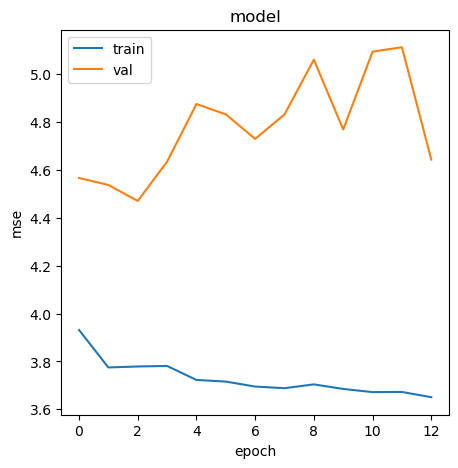

In [29]:
# building model_updrs_1 for updrs_1
features_dim = seq_gen_train_f.shape[2] # number of features
out_dim = target_updrs_1.shape[1] 
#print(target_updrs_1[:5])
print("working on model_updrs_1")
print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

model_updrs_1 = Sequential()

# Understanding of return_sequences and connection across LSTM layers
model_updrs_1.add(LSTM(
input_shape=(sequence_length, features_dim),
        units=100,
         return_sequences=True))
model_updrs_1.add(Dropout(0.2))

model_updrs_1.add(LSTM(
          units=50,
          return_sequences=False))
model_updrs_1.add(Dropout(0.2))

    # output layer
model_updrs_1.add(Dense(1))
model_updrs_1.add(Activation("linear"))

    # Compile the model_updrs_1
model_updrs_1.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

    #print(model_updrs_1.summary())

    # Define path to save model_updrs_1
model_updrs_1_path_updrs_1 = "/kaggle/working/updrs_1_binary_model_updrs_1.h5"
    
epochs = 30
batch_size = 100
start = time.time()
    # Fit the network
history_updrs_1 = model_updrs_1.fit(seq_gen_train_f, target_updrs_1, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_updrs_1_path_updrs_1, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")
train_predict_updrs_1 = model_updrs_1.predict(seq_gen_train_f)
print(train_predict_updrs_1.shape)
print(train_predict_updrs_1)
test_predict_updrs_1 = model_updrs_1.predict(seq_gen_test_f)
print(test_predict_updrs_1.shape)
print(test_predict_updrs_1)
plot_model_accuracy(history_updrs_1, 5, 5)

working on model_updrs_2
Features dimension:  4
Output dimension:  1
Epoch 1/30
2018/2018 - 138s - loss: 4.0568 - mean_absolute_error: 4.0568 - val_loss: 4.1450 - val_mean_absolute_error: 4.1450 - 138s/epoch - 69ms/step
Epoch 2/30
2018/2018 - 130s - loss: 3.9645 - mean_absolute_error: 3.9645 - val_loss: 3.8263 - val_mean_absolute_error: 3.8263 - 130s/epoch - 65ms/step
Epoch 3/30
2018/2018 - 127s - loss: 3.8921 - mean_absolute_error: 3.8921 - val_loss: 4.0310 - val_mean_absolute_error: 4.0310 - 127s/epoch - 63ms/step
Epoch 4/30
2018/2018 - 147s - loss: 3.7332 - mean_absolute_error: 3.7332 - val_loss: 4.0334 - val_mean_absolute_error: 4.0334 - 147s/epoch - 73ms/step
Epoch 5/30
2018/2018 - 126s - loss: 3.7234 - mean_absolute_error: 3.7234 - val_loss: 3.9296 - val_mean_absolute_error: 3.9296 - 126s/epoch - 62ms/step
Epoch 6/30
2018/2018 - 127s - loss: 3.7162 - mean_absolute_error: 3.7162 - val_loss: 4.1135 - val_mean_absolute_error: 4.1135 - 127s/epoch - 63ms/step
Epoch 7/30
2018/2018 - 12

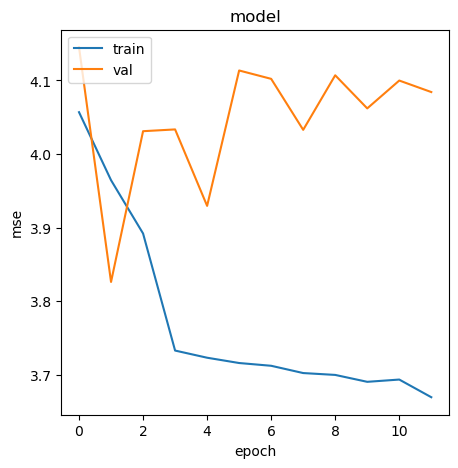

In [30]:
# building model_updrs_2 for updrs_2
print("working on model_updrs_2")
features_dim = seq_gen_train_f.shape[2] # number of features
out_dim = target_updrs_2.shape[1] 
#print(target_updrs_2[:5])

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

model_updrs_2 = Sequential()

# Understanding of return_sequences and connection across LSTM layers
model_updrs_2.add(LSTM(
input_shape=(sequence_length, features_dim),
        units=100,
         return_sequences=True))
model_updrs_2.add(Dropout(0.2))

model_updrs_2.add(LSTM(
          units=50,
          return_sequences=False))
model_updrs_2.add(Dropout(0.2))

    # output layer
model_updrs_2.add(Dense(1))
model_updrs_2.add(Activation("linear"))

model_updrs_2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

#print(model_updrs_2.summary())

model_updrs_2_path_updrs_2 = "/kaggle/working/updrs2_binary_model_updrs_2.h5"
    
epochs = 30
batch_size = 100
start = time.time()
    # Fit the network
history_updrs_2 = model_updrs_2.fit(seq_gen_train_f, target_updrs_2, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_updrs_2_path_updrs_2, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")
train_predict_updrs_2 = model_updrs_2.predict(seq_gen_train_f)
print(train_predict_updrs_2.shape)
print(train_predict_updrs_2)
test_predict_updrs_2 = model_updrs_2.predict(seq_gen_test_f)
print(test_predict_updrs_2.shape)
print(test_predict_updrs_2)
plot_model_accuracy(history_updrs_2, 5, 5)

working on model_updrs_3
Features dimension:  4
Output dimension:  1
Epoch 1/30
2018/2018 - 129s - loss: 12.6476 - mean_absolute_error: 12.6476 - val_loss: 11.6683 - val_mean_absolute_error: 11.6683 - 129s/epoch - 64ms/step
Epoch 2/30
2018/2018 - 109s - loss: 10.6329 - mean_absolute_error: 10.6329 - val_loss: 12.9512 - val_mean_absolute_error: 12.9512 - 109s/epoch - 54ms/step
Epoch 3/30
2018/2018 - 121s - loss: 9.0247 - mean_absolute_error: 9.0247 - val_loss: 12.3057 - val_mean_absolute_error: 12.3057 - 121s/epoch - 60ms/step
Epoch 4/30
2018/2018 - 119s - loss: 8.9376 - mean_absolute_error: 8.9376 - val_loss: 12.5410 - val_mean_absolute_error: 12.5410 - 119s/epoch - 59ms/step
Epoch 5/30
2018/2018 - 121s - loss: 8.9541 - mean_absolute_error: 8.9541 - val_loss: 12.3915 - val_mean_absolute_error: 12.3915 - 121s/epoch - 60ms/step
Epoch 6/30
2018/2018 - 131s - loss: 8.9515 - mean_absolute_error: 8.9515 - val_loss: 12.2318 - val_mean_absolute_error: 12.2318 - 131s/epoch - 65ms/step
Epoch 7/3

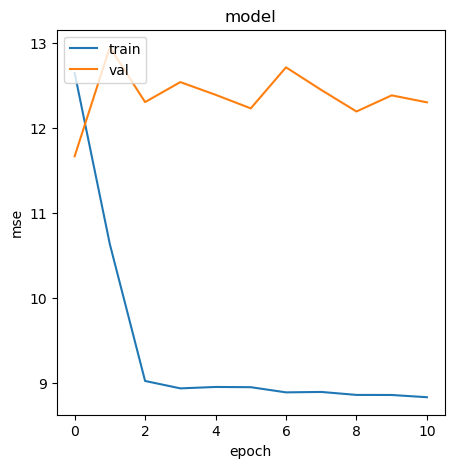

In [31]:
print("working on model_updrs_3")
# building model_updrs_3 for updrs_3
features_dim = seq_gen_train_f.shape[2] # number of features
out_dim = target_updrs_3.shape[1] 
#print(target_updrs_3[:5])

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

model_updrs_3 = Sequential()

# Understanding of return_sequences and connection across LSTM layers
model_updrs_3.add(LSTM(
input_shape=(sequence_length, features_dim),
        units=100,
         return_sequences=True))
model_updrs_3.add(Dropout(0.2))

model_updrs_3.add(LSTM(
          units=50,
          return_sequences=False))
model_updrs_3.add(Dropout(0.2))

    # output layer
model_updrs_3.add(Dense(1))
model_updrs_3.add(Activation("linear"))

model_updrs_3.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

#print(model_updrs_3.summary())

model_updrs_3_path_updrs_3 = "/kaggle/working/updrs3_binary_model_updrs_3.h5"
    
epochs = 30
batch_size = 100
start = time.time()
    # Fit the network
history_updrs_3 = model_updrs_3.fit(seq_gen_train_f, target_updrs_3, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_updrs_3_path_updrs_3, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")
train_predict_updrs_3 = model_updrs_3.predict(seq_gen_train_f)
print(train_predict_updrs_3.shape)
print(train_predict_updrs_3)
test_predict_updrs_3 = model_updrs_3.predict(seq_gen_test_f)
print(test_predict_updrs_3.shape)
print(test_predict_updrs_3)
plot_model_accuracy(history_updrs_3, 5, 5)

working on model_updrs_4
Features dimension:  4
Output dimension:  1
Epoch 1/30
2018/2018 - 127s - loss: 1.0250 - mean_absolute_error: 1.0250 - val_loss: 1.2835 - val_mean_absolute_error: 1.2835 - 127s/epoch - 63ms/step
Epoch 2/30
2018/2018 - 117s - loss: 1.0241 - mean_absolute_error: 1.0241 - val_loss: 1.2836 - val_mean_absolute_error: 1.2836 - 117s/epoch - 58ms/step
Epoch 3/30
2018/2018 - 120s - loss: 1.0241 - mean_absolute_error: 1.0241 - val_loss: 1.2836 - val_mean_absolute_error: 1.2836 - 120s/epoch - 59ms/step
Epoch 4/30
2018/2018 - 126s - loss: 1.0241 - mean_absolute_error: 1.0241 - val_loss: 1.2836 - val_mean_absolute_error: 1.2836 - 126s/epoch - 62ms/step
Epoch 5/30
2018/2018 - 138s - loss: 1.0241 - mean_absolute_error: 1.0241 - val_loss: 1.2836 - val_mean_absolute_error: 1.2836 - 138s/epoch - 68ms/step
Epoch 6/30
2018/2018 - 147s - loss: 1.0241 - mean_absolute_error: 1.0241 - val_loss: 1.2836 - val_mean_absolute_error: 1.2836 - 147s/epoch - 73ms/step
Epoch 7/30
2018/2018 - 12

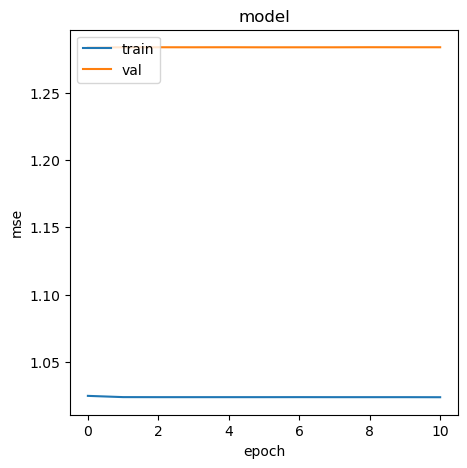

In [32]:
# building model_updrs_4 for updrs_4
print("working on model_updrs_4")
features_dim = seq_gen_train_f.shape[2] # number of features
out_dim = target_updrs_4.shape[1] 
#print(target_updrs_4[:5])

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

model_updrs_4 = Sequential()

# Understanding of return_sequences and connection across LSTM layers
model_updrs_4.add(LSTM(
input_shape=(sequence_length, features_dim),
        units=100,
         return_sequences=True))
model_updrs_4.add(Dropout(0.2))

model_updrs_4.add(LSTM(
          units=50,
          return_sequences=False))
model_updrs_4.add(Dropout(0.2))

    # output layer
model_updrs_4.add(Dense(1))
model_updrs_4.add(Activation("linear"))

model_updrs_4.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

#print(model_updrs_3.summary())

model_updrs_4_path_updrs_4 = "/kaggle/working/updrs4_binary_model_updrs_4.h5"
    
epochs = 30
batch_size = 100
start = time.time()
    # Fit the network
history_updrs_4 = model_updrs_4.fit(seq_gen_train_f, target_updrs_4, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_updrs_4_path_updrs_4, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")
train_predict_updrs_4 = model_updrs_4.predict(seq_gen_train_f)
print(train_predict_updrs_4.shape)
print(train_predict_updrs_4)
test_predict_updrs_4 = model_updrs_4.predict(seq_gen_test_f)
print(test_predict_updrs_4.shape)
print(test_predict_updrs_4)
plot_model_accuracy(history_updrs_4, 5, 5)

In [33]:
pred_df['prediction_updrs_1'] = test_predict_updrs_1
pred_df['prediction_updrs_2'] = test_predict_updrs_2
pred_df['prediction_updrs_3'] = test_predict_updrs_3
pred_df['prediction_updrs_4'] = test_predict_updrs_4
pred_df.head(5)

,visit_id,visit_month,patient_id,updrs_test,row_id,prediction_updrs_1,prediction_updrs_2,prediction_updrs_3,prediction_updrs_4
0,3342_0,0,3342,updrs_1,3342_0_updrs_1,3.948010,2.824734,10.900830,-0.000087
1,3342_0,0,3342,updrs_2,3342_0_updrs_2,3.948010,2.824734,10.900830,-0.000087
2,3342_0,0,3342,updrs_3,3342_0_updrs_3,3.948010,2.824734,10.900830,-0.000087
3,3342_0,0,3342,updrs_4,3342_0_updrs_4,3.948010,2.824734,10.900830,-0.000087
4,50423_0,0,50423,updrs_1,50423_0_updrs_1,3.730886,2.773668,10.213562,-0.000078


In [34]:
final_predicts = pred_df.groupby(['row_id', 'visit_month','visit_id','updrs_test'])\
['prediction_updrs_1','prediction_updrs_2','prediction_updrs_3', 'prediction_updrs_4'].mean().reset_index()
final_predicts

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,row_id,visit_month,visit_id,updrs_test,prediction_updrs_1,prediction_updrs_2,prediction_updrs_3,prediction_updrs_4
0,3342_0_updrs_1,0,3342_0,updrs_1,3.948010,2.824734,10.900830,-0.000087
1,3342_0_updrs_2,0,3342_0,updrs_2,3.948010,2.824734,10.900830,-0.000087
2,3342_0_updrs_3,0,3342_0,updrs_3,3.948010,2.824734,10.900830,-0.000087
3,3342_0_updrs_4,0,3342_0,updrs_4,3.948010,2.824734,10.900830,-0.000087
4,3342_6_updrs_1,6,3342_6,updrs_1,2.360971,0.196046,0.079655,-0.000090
5,3342_6_updrs_2,6,3342_6,updrs_2,2.360971,0.196046,0.079655,-0.000090
6,3342_6_updrs_3,6,3342_6,updrs_3,2.360971,0.196046,0.079655,-0.000090
7,3342_6_updrs_4,6,3342_6,updrs_4,2.360971,0.196046,0.079655,-0.000090
8,50423_0_updrs_1,0,50423_0,updrs_1,3.922827,2.834916,10.824754,-0.000084
9,50423_0_updrs_2,0,50423_0,updrs_2,3.922827,2.834916,10.824754,-0.000084


In [35]:
def map_test(x):
    updrs = x.split('_')[2] + '_' + x.split('_')[3]
    #print(updrs)
    month = int(x.split('_plus_')[1].split('_')[0])
    #print(month)
    visit_id = x.split('_')[0] + '_' + x.split('_')[1]
    #print(visit_id)
    if updrs=='updrs_1':
        check = df[(df.visit_id == visit_id) & (df.visit_month == month)]['prediction_updrs_1']
        if(check.shape[0] == 0):
            rating = df[df.visit_id == visit_id]['prediction_updrs_1'].values[0]
        else : 
            rating = check.values[0]
    elif updrs=='updrs_2':
        check = df[(df.visit_id == visit_id) & (df.visit_month == month)]['prediction_updrs_2']
        if(check.shape[0] == 0):
            rating = df[df.visit_id == visit_id]['prediction_updrs_2'].values[0]
        else : 
            rating = check.values[0]
    elif updrs =='updrs_3':
        check = df[(df.visit_id == visit_id) & (df.visit_month == month)]['prediction_updrs_3']
        if(check.shape[0] == 0):
            rating = df[df.visit_id == visit_id]['prediction_updrs_3'].values[0]
        else : 
            rating = check.values[0]
    elif updrs =='updrs_4':
        check = df[(df.visit_id == visit_id) & (df.visit_month == month)]['prediction_updrs_4']
        if(check.shape[0] == 0):
            rating = df[df.visit_id == visit_id]['prediction_updrs_4'].values[0]
        else : 
            rating = check.values[0]
    return rating

In [36]:
import amp_pd_peptide
env = amp_pd_peptide.make_env()
iter_test = env.iter_test()

In [37]:
for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    
    data_prep_test = data_prep(test, test_peptides, test_proteins, train=0)
    data_prep_test = data_prep_test.fillna(0)
    #display(data_prep_test)
    test_seq_gen_test_f = test_seq_gen(data_prep_test)
    print(test_seq_gen_test_f.shape)
    pred_df_test = test_data_save(data_prep_test)
    print(pred_df_test.shape)
    #display(pred_df_test)
    test_updrs_1 = model_updrs_1.predict(test_seq_gen_test_f)
    test_updrs_2 = model_updrs_2.predict(test_seq_gen_test_f)
    test_updrs_3 = model_updrs_3.predict(test_seq_gen_test_f)
    test_updrs_4 = model_updrs_4.predict(test_seq_gen_test_f)
    
    pred_df_test['prediction_updrs_1'] = test_updrs_1
    pred_df_test['prediction_updrs_2'] = test_updrs_2
    pred_df_test['prediction_updrs_3'] = test_updrs_3
    pred_df_test['prediction_updrs_4'] = test_updrs_4
    #display(pred_df_test)
    
    df = pred_df_test.groupby(['row_id', 'visit_month','visit_id','updrs_test'])\
    ['prediction_updrs_1','prediction_updrs_2','prediction_updrs_3', 'prediction_updrs_4'].mean().reset_index()
    
    sample_submission['rating'] = sample_submission['prediction_id'].apply(map_test)

    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
(712, 50, 4)
(712, 5)
23/23 [==============================] - 0s 14ms/step
(708, 50, 4)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(708, 5)
23/23 [==============================] - 0s 12ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [38]:
#df

In [39]:
#sample_submission['rating'] = sample_submission['prediction_id'].apply(map_test)
#sample_submission